<a href="https://colab.research.google.com/github/taceroc/light_echo_modeling/blob/main/delta_dependence_func.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib


from astropy.coordinates import (cartesian_to_spherical, SkyCoord, Distance, Galactic, EarthLocation, AltAz, CartesianRepresentation, SphericalRepresentation)
from astropy import units as u
# Calculate observer's local sidereal time (LST)
from astropy.time import Time
from astropy.coordinates import EarthLocation

%config InlineBackend.figure_format='retina'

In [2]:
def scatter_phase_function(g = 0, scatter_angle = np.pi / 2):
  mu =  np.cos(scatter_angle)
  return ((1 - g**2) / (1 + g**2  - 2 * g * mu)**(3/2) ) / 4 * np.pi

In [3]:
Deltat = [280] # days
dtoy = 0.00273973 # 1 day = 0.00273973 y
Deltat_y = np.array(Deltat) * dtoy
z0 = [-0.10, 0, 0.3, 1] # pc
pctoly = 3.26156 # 1pc = 3.26156 light-year
z0ly = np.array(z0) * pctoly
# -- point where the plane-parallel slab of dust intersects the line of sight
# -- inclination of the plane, is perpendicular to the line of sight (I am using 89 so the tangent don't die)
alpha = 20 * np.pi/180  # angle of tilt in radians
a = np.tan(alpha)
dt0 = 50 * dtoy
dz0 = 0.02 * pctoly # in ly

c = 1 # in light-year / year
pctom = 3.086e+16
n = 2.3 * (100 ** 3) #m-3
n = n * ( pctom ** 3 ) / ( pctoly ** 3 )
sigma = 5e-22 / (100 ** 2) #m2 #RR paper
sigma = ( sigma / ( (pctom ** 2) ) ) * ( pctoly ** 2 )
albedo = 0.6
Fphi = scatter_phase_function()
print(Fphi, 1/4 * np.pi)
# -- distance source - observer
dkpc = 5 #kpc
d = dkpc * 1000 * pctoly

k = sigma * albedo * Fphi
# L = 15,000 x 3.9e26 # watts = kg m ^2 / s^3
L = (15000 * 3.9e36) * ((60 * 60 * 24 * 365) ** 3) * (pctoly ** 2) / (pctom ** 2)
Ir = k * L * c / (4 * np.pi * (dkpc * 1000 * pctoly)**2)

0.7853981633974483 0.7853981633974483


In [4]:
def rude_function_delta_dependence(delta_deg, alpha_deg, z0ly, Deltat_y, n_h = n):
  """
    z0ly: in ly
    Delta_degt_y: in y
    delta_deg: in deg
    alpha: in deg
  """

  # -- alpha_deg: angle between the normal of the dust plane and the line of sight
  a = np.tan(np.deg2rad(alpha_deg))
  ct = c * Deltat_y
  r_le = np.sqrt(2 * z0ly * ct + (ct)**2 * (1 + a**2) )
  r_le2 = r_le**2

  x = np.linspace(-10, 10, 1000)
  # -- delta = arctan2(x/z(y)),  x^2 + y^2 = 2zct + (ct)^2 x is from the paraboloid, y_inv paraboloid
  y_inv = ( (2 * ct * x) - ((x ** 2 - (ct)**2 ) * np.tan(np.deg2rad(delta_deg)) )) / (np.tan(np.deg2rad(delta_deg)))

  # -- intersection parabolid and plane + and - solution of the square root
  x_inter_inv = np.sqrt(r_le2 - y_inv**2) - a * ct
  x_inter_inv_n = -1*np.sqrt(r_le2 - y_inv**2) - a * ct

  x_inter = x_inter_inv.copy()
  # -- not all the values are possible because not all paraboloid cross the plane, and r_le^2 > y paraboloid. keep non nan
  x_inter_nan_values = x_inter[~np.isnan(x_inter)]

  # -- the z intersection of the plane
  z_inter_non = z0ly - a * x_inter_nan_values

  # let's assume that the density follows a uniform distribution around nH. and it only exist for the non nan values
  np.random.seed(52+int(delta_deg))
  grid = np.random.uniform(0, 1, (len(x_inter_nan_values), len(z_inter_non)))
  data_cube = np.zeros((len(x_inter_nan_values), len(z_inter_non), 3))

  for i in range(len(x_inter_nan_values)):
      for j in range(len(z_inter_non)):
        if i == j:
          data_cube[i, i, 0] = x_inter_nan_values[i]
          data_cube[i, i, 1] = z_inter_non[i]
          # print(grid[i,i])
          # print(data_cube[i,i,2])
          # print(n)
          data_cube[i, i, 2] = grid[i, i] * n_h
        else:
          data_cube[i, j, 0] = x_inter_nan_values[i]
          data_cube[i, j, 1] = z_inter_non[j]
          data_cube[i, j, 2] = 0

  # -- r
  r = z_inter_non + ct

  # -- rho = x^2 + y^2 = r_le
  rhodrho  = (dz0 * ct) + (z_inter_non * c * dt0) + ct * dt0 * (1 + a**2)


  surface = np.zeros(len(r))
  for ff in range(len(x_inter_nan_values)):
      surface[ff] = Ir * data_cube[ff, ff, 2] * dz0 / ( 4 * np.pi * r[ff] * rhodrho[ff] )



  # THE PROJECTED PLANE RESULT OF THE INTERSECTION BETWEEN PARABOLOID AND PLANE
  # -- arctan2 return values (-pi, pi), transform so it is in the (0, 2pi) range
  phis = np.mod(np.arctan2(y_inv[~np.isnan(x_inter_inv)], x_inter_inv[~np.isnan(x_inter_inv)]), 2*np.pi)
  phis_n = np.mod(np.arctan2(y_inv[~np.isnan(x_inter_inv_n)], x_inter_inv_n[~np.isnan(x_inter_inv_n)]), 2*np.pi)

  # -- thickness of the LE
  half_obs_thickness = np.sqrt( (ct / r_le) ** 2 * dz0 ** 2 + ( (r_le * c / 2 * ct) + ( c * ct / 2 * r_le )) ** 2 * dt0  ** 2 ) / 2
  # -- include the thickness in xy plane
  r_le_out= r_le + half_obs_thickness
  # -- in arcseconds 5kpc = 16308 ly
  # -- degree to arcseconds
  r_le_out = np.arctan(r_le_out / d) * (180 / np.pi) * 3600
  r_le_in = r_le - half_obs_thickness
  r_le_in = np.arctan(r_le_in / d) * (180 / np.pi) * 3600
  # -- in arcseconds too
  act = np.arctan(a * ct / d) * (180 / np.pi) * 3600

  radii_p = [r_le_out, r_le_in]
  xs_p = np.outer(radii_p, np.cos(phis)) - act
  ys_p = np.outer(radii_p, np.sin(phis))

  new_xs = xs_p.reshape(1,2,len(phis))
  new_ys = ys_p.reshape(1,2,len(phis))


  # ----- other half //  negative root
  xs_p_h = np.outer(radii_p, np.cos(phis_n)) - act
  ys_p_h = np.outer(radii_p, np.sin(phis_n))


  new_xs_h = xs_p_h.reshape(1,2,len(phis))
  new_ys_h = ys_p_h.reshape(1,2,len(phis))

  return new_xs, new_ys, new_xs_h, new_ys_h, surface, act, r_le, a


In [5]:
def several_deltas(deltass, alpha_deg, z0ly, Deltat_y):
  """
    Calculate the x,y and surface brightness of the LE for the same alpha, z0 and time for different angle between line of sight and dust plane

    Arguments:
      deltass: np.array of the angles to take into account
      alpha_deg: angle normal dust plane and z axis (line of sight) in degrees
      z0ly: position of the dust plane in ly
      Deltat_y: time when the "snap" of the LE is taken from the observer in years
  """
  new_xs_list = []
  new_ys_list = []

  new_xs_h_list = []
  new_ys_h_list = []

  surface_list = []
# (delta_deg, alpha_deg, z0ly, Deltat_y, n_h = n)
  # deltass = np.linspace(0, 360, 100)
  for deltas in deltass:
    new_xs, new_ys, new_xs_h, new_ys_h, surface, act, r_le, a = rude_function_delta_dependence(deltas, alpha_deg, z0ly, Deltat_y)
    new_xs_list.append(new_xs)
    new_ys_list.append(new_ys)
    new_xs_h_list.append(new_xs_h)
    new_ys_h_list.append(new_ys_h)
    surface_list.append(surface)

  new_xs = np.concatenate(new_xs_list, axis = 2)
  new_ys = np.concatenate(new_ys_list, axis = 2)

  new_xs_h = np.concatenate(new_xs_h_list, axis = 2)
  new_ys_h = np.concatenate(new_ys_h_list, axis = 2)

  surface = np.concatenate(surface_list)

  return new_xs, new_ys, new_xs_h, new_ys_h, surface, r_le, act

In [6]:
def plot_deltas(new_xs, new_ys, new_xs_h, new_ys_h, surface, deltass, alpha_deg, r_le, act, z):
  fig, ax = plt.subplots(1, 1, figsize=(12, 8))


  surface_300_norm = ( surface - np.nanmin(surface)  ) / (np.nanmax(surface) - np.nanmin(surface))
  cmap = matplotlib.colormaps.get_cmap('magma_r')
  normalize = matplotlib.colors.Normalize(vmin=np.nanmin(surface_300_norm), vmax=np.nanmax(surface_300_norm))
  # sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
  # sm.set_array([])

  # array_color = np.array([cmap(normalize(surface_300_norm))])
  # print(surface_300_norm.shape)
  ax.set_title("density define only for %s degrees and a = tan(%s)"%([deltass.min(), deltass.max()], int(alpha_deg)))

  r_le_arc = np.arctan(r_le / d) * (180 / np.pi) * 3600
  ax.set_xlim(-act - r_le_arc - 10, -act + r_le_arc + 10)
  ax.set_ylim(-r_le_arc - 10, r_le_arc + 10)

  for k in range(len(surface)):
    ax.plot(new_xs[0, :, k], new_ys[0, :, k], color=cmap(normalize(surface_300_norm[k])))#, label="%s"%(z/pctoly))
    ax.plot(new_xs_h[0, :, k], new_ys_h[0, :, k], color=cmap(normalize(surface_300_norm[k])))#, label="%s"%(z/pctoly))
  # print(array_color.shape)
  # ax.plot(new_xs[0, :, :], new_ys[0, :, :], color=sm)#, label="%s"%(z/pctoly))

  ax.scatter(- act, 0, marker = "*", color = "purple")
  ax.scatter(0, 0, marker = "*", color = "crimson")

  ax.legend(z, loc='best')

  cbax = fig.add_axes([0.96, 0.1, 0.03, 0.80])

  ax.set_xlabel("arcsec")
  ax.set_ylabel("arcsec")
  ax.set_aspect('equal')

  cb1 = matplotlib.colorbar.ColorbarBase(cbax, cmap=cmap, norm=normalize, orientation='vertical')
  cb1.set_label("Surface Brightness (Log)", rotation=270, labelpad=15)

  def label_cbrt(x,pos):
      return "{:.1f}".format(x)

  cb1.formatter = matplotlib.ticker.FuncFormatter(label_cbrt)
  # cb.update_ticks()
  # # plt.tight_layout()
  # # plt.savefig("figure2.png", dpi = 700, bbox_inches='tight')
  # # print(set(legend_dust))
  # plt.show()

  return fig, ax

<ipython-input-4-93c2c970093f>:17: RuntimeWarning: divide by zero encountered in true_divide
  y_inv = ( (2 * ct * x) - ((x ** 2 - (ct)**2 ) * np.tan(np.deg2rad(delta_deg)) )) / (np.tan(np.deg2rad(delta_deg)))
<ipython-input-4-93c2c970093f>:20: RuntimeWarning: invalid value encountered in sqrt
  x_inter_inv = np.sqrt(r_le2 - y_inv**2) - a * ct
<ipython-input-4-93c2c970093f>:21: RuntimeWarning: invalid value encountered in sqrt
  x_inter_inv_n = -1*np.sqrt(r_le2 - y_inv**2) - a * ct


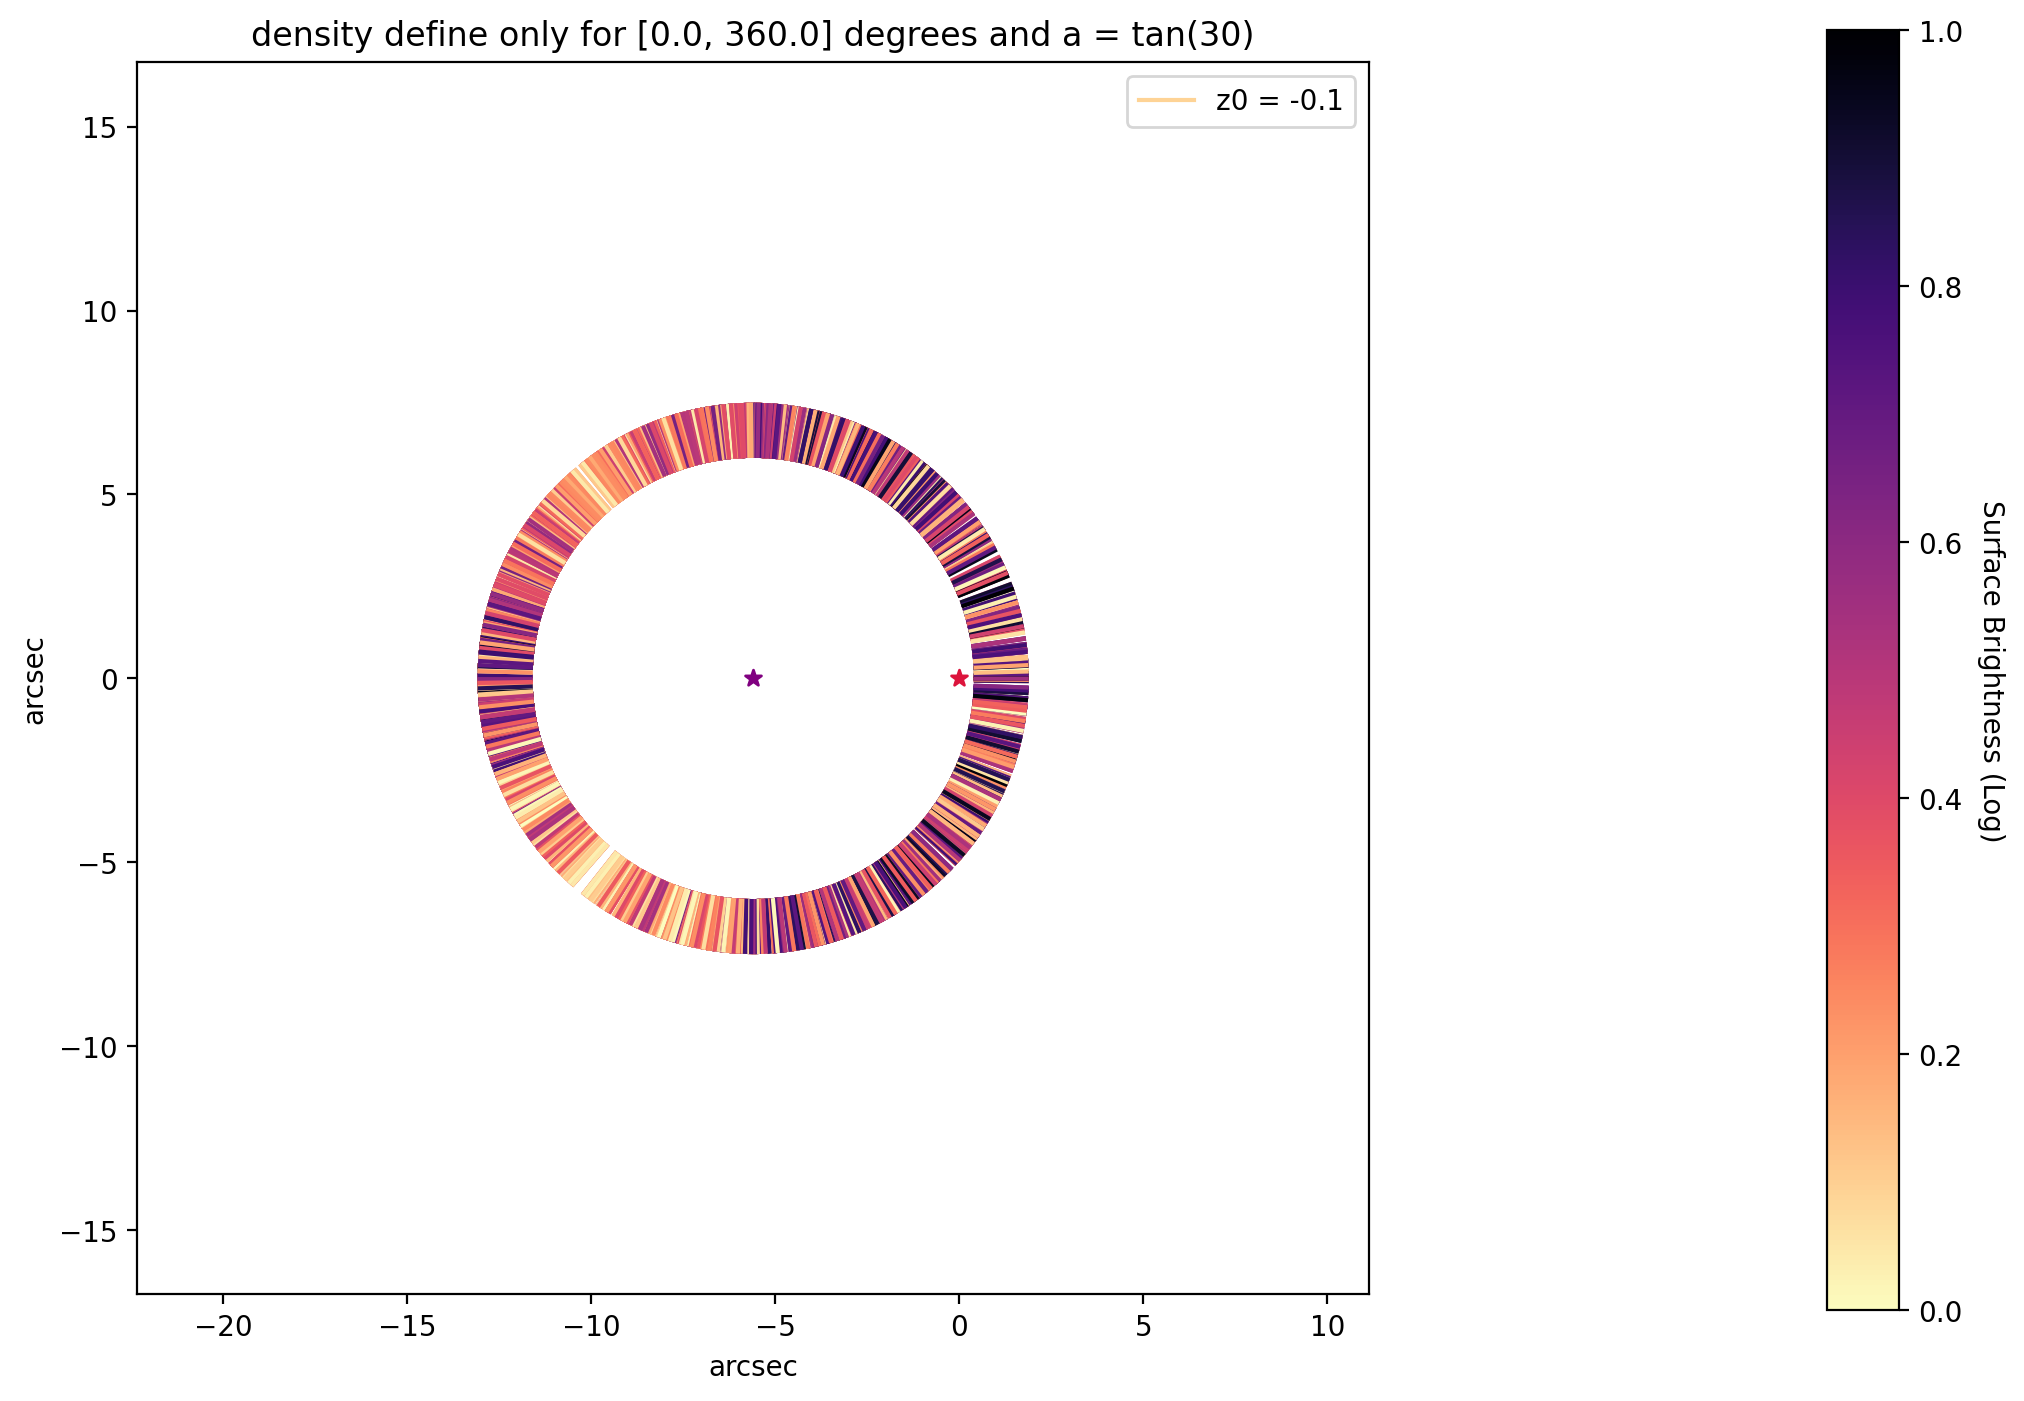

In [7]:
deltass = np.linspace(0, 360, 100)
alpha_deg = 30
zly = z0ly[0]
new_xs, new_ys, new_xs_h, new_ys_h, surface, r_le, act = several_deltas(deltass, alpha_deg, zly, Deltat_y)
fig, ax = plot_deltas(new_xs, new_ys, new_xs_h, new_ys_h, surface, deltass, alpha_deg, r_le, act, [zly/pctoly])

ax.set_title("density define only for %s degrees and a = tan(%s)"%([deltass.min(), deltass.max()], int(alpha_deg)))
ax.legend(["z0 = %s"%(zly / pctoly)])

In [8]:
new_ys.shape

(1, 2, 4720)

In [9]:
surface.shape

(4720,)

In [10]:
# surface_300_norm = ( surface - np.nanmin(surface)  ) / (np.nanmax(surface) - np.nanmin(surface))
# cmap = matplotlib.colormaps.get_cmap('magma_r')
# normalize = matplotlib.colors.Normalize(vmin=np.nanmin(surface_300_norm), vmax=np.nanmax(surface_300_norm))
# data_array = np.array([cmap(normalize(surface_300_norm))])
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=y[0],vmax=y[-1]))
# # for new_xs, new_ys, color in data_array:
# plt.plot(new_xs[0,:,:], new_ys[0,:,:], color=data_array[0,0,:])
#   # ax.plot(new_xs_h[0, :, k], new_ys_h[0, :, k], color=color)

<ipython-input-4-93c2c970093f>:17: RuntimeWarning: divide by zero encountered in true_divide
  y_inv = ( (2 * ct * x) - ((x ** 2 - (ct)**2 ) * np.tan(np.deg2rad(delta_deg)) )) / (np.tan(np.deg2rad(delta_deg)))
<ipython-input-4-93c2c970093f>:20: RuntimeWarning: invalid value encountered in sqrt
  x_inter_inv = np.sqrt(r_le2 - y_inv**2) - a * ct
<ipython-input-4-93c2c970093f>:21: RuntimeWarning: invalid value encountered in sqrt
  x_inter_inv_n = -1*np.sqrt(r_le2 - y_inv**2) - a * ct


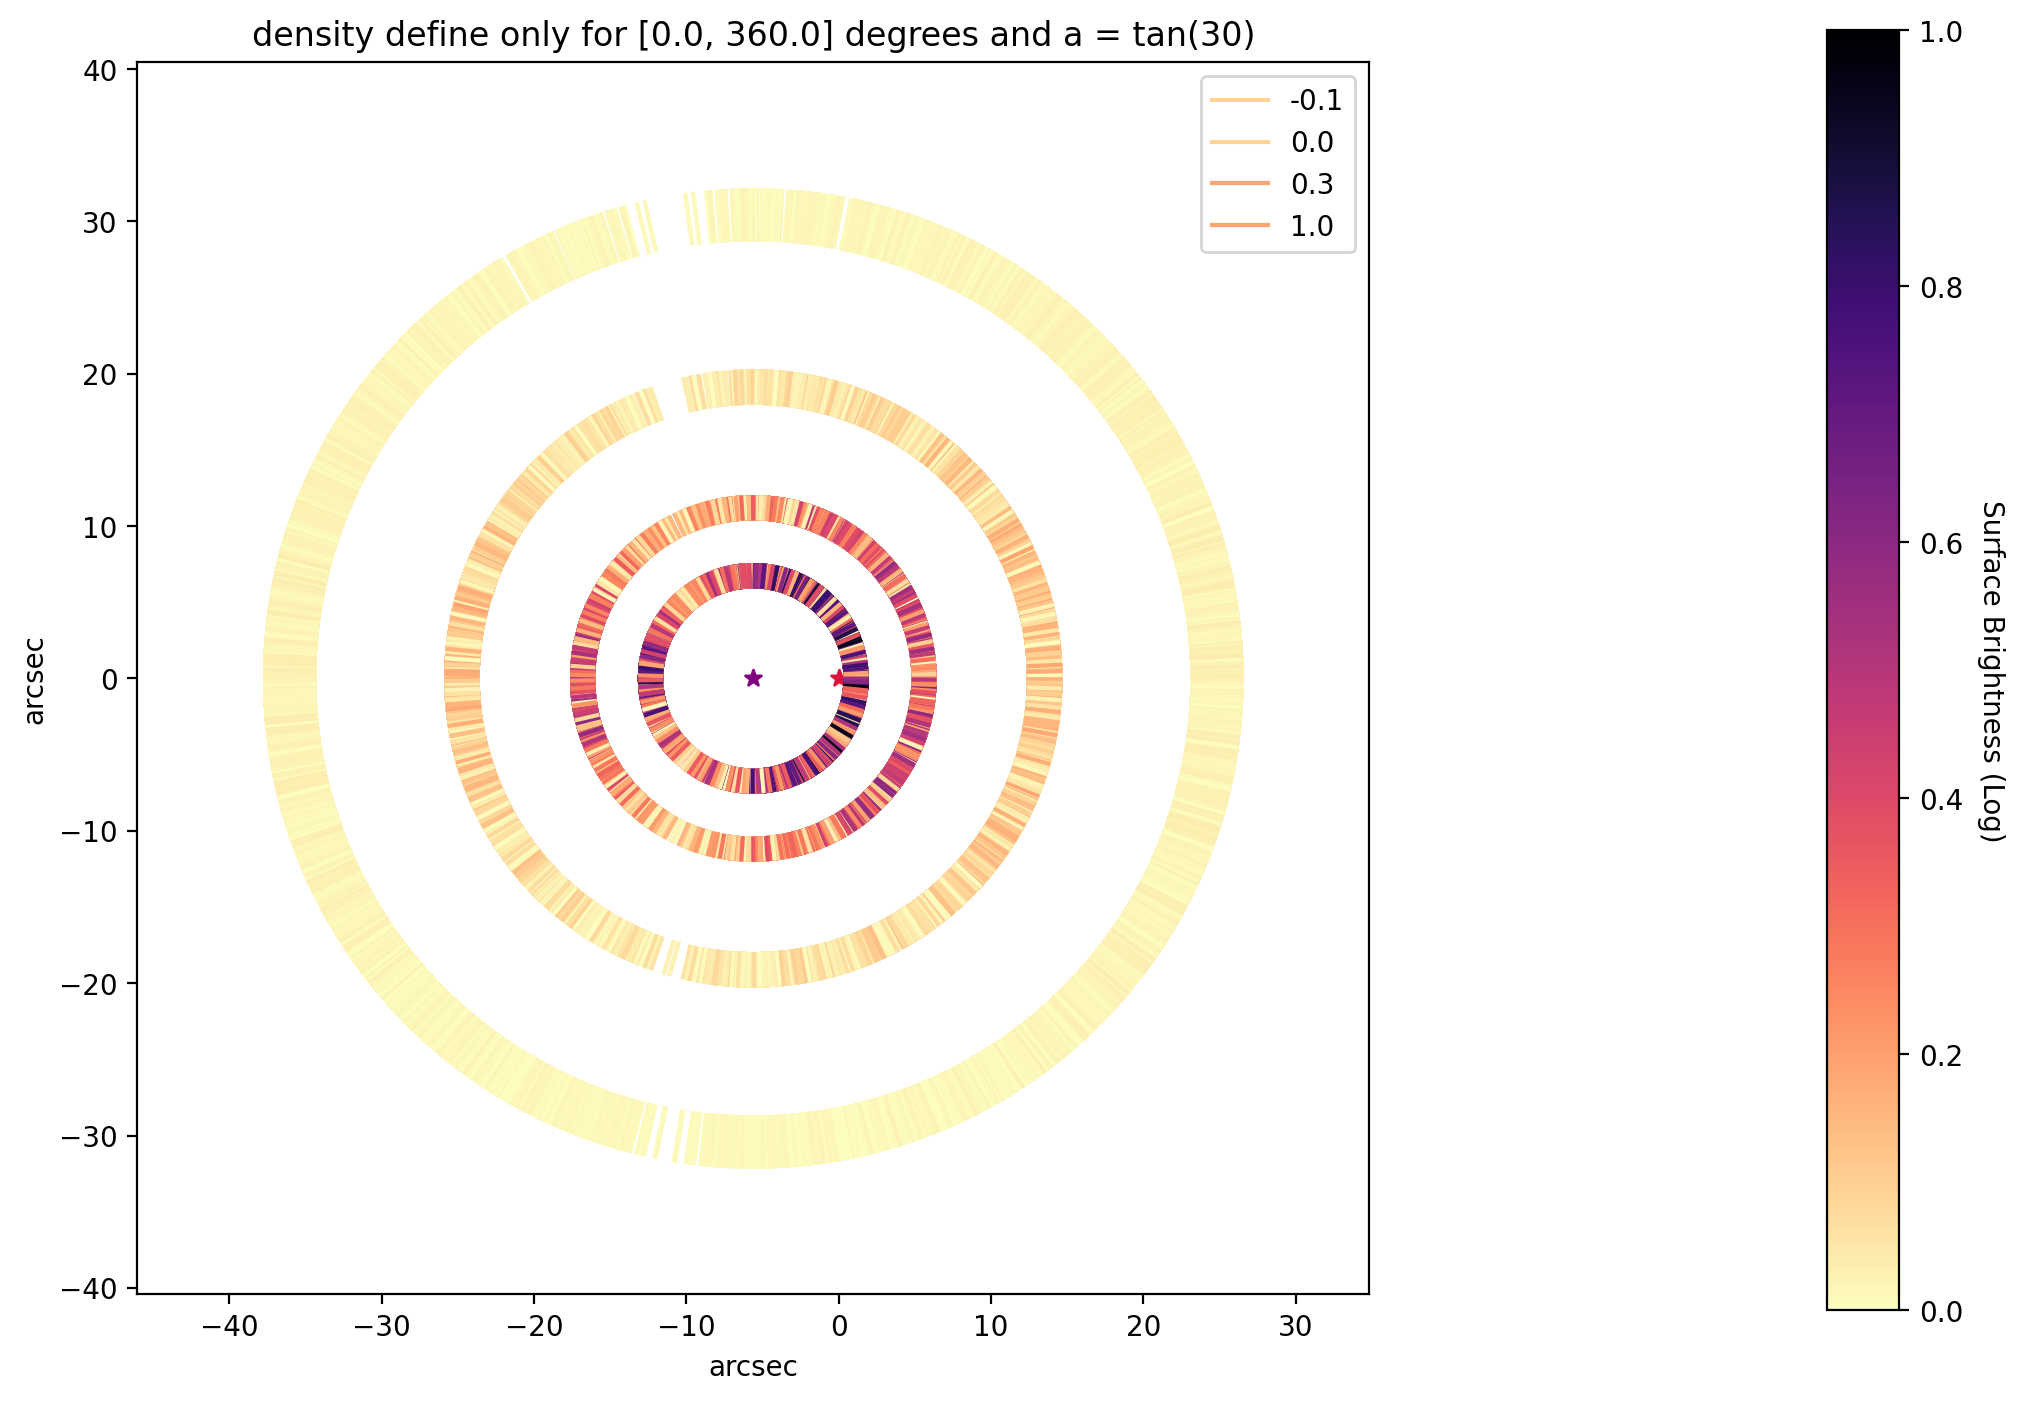

In [20]:
deltass = np.linspace(0, 360, 100)
alpha_deg = 30
# zly = z0ly[0]
new_xs_list = []
new_ys_list = []

new_xs_h_list = []
new_ys_h_list = []

surface_list = []

for zz in z0ly:
  new_xs, new_ys, new_xs_h, new_ys_h, surface, r_le, act = several_deltas(deltass, alpha_deg, zz, Deltat_y)
  new_xs_list.append(new_xs)
  new_ys_list.append(new_ys)
  new_xs_h_list.append(new_xs_h)
  new_ys_h_list.append(new_ys_h)
  surface_list.append(surface)

new_xs = np.concatenate(new_xs_list, axis = 2)
new_ys = np.concatenate(new_ys_list, axis = 2)

new_xs_h = np.concatenate(new_xs_h_list, axis = 2)
new_ys_h = np.concatenate(new_ys_h_list, axis = 2)

surface = np.concatenate(surface_list)
fig, ax = plot_deltas(new_xs, new_ys, new_xs_h, new_ys_h, surface, deltass, alpha_deg, r_le, act, z0ly/pctoly)

<ipython-input-4-93c2c970093f>:20: RuntimeWarning: invalid value encountered in sqrt
  x_inter_inv = np.sqrt(r_le2 - y_inv**2) - a * ct
<ipython-input-4-93c2c970093f>:21: RuntimeWarning: invalid value encountered in sqrt
  x_inter_inv_n = -1*np.sqrt(r_le2 - y_inv**2) - a * ct


(<Figure size 1200x800 with 2 Axes>,
 <Axes: title={'center': 'density define only for [10.0, 36.0] degrees and a = tan(30)'}, xlabel='arcsec', ylabel='arcsec'>)

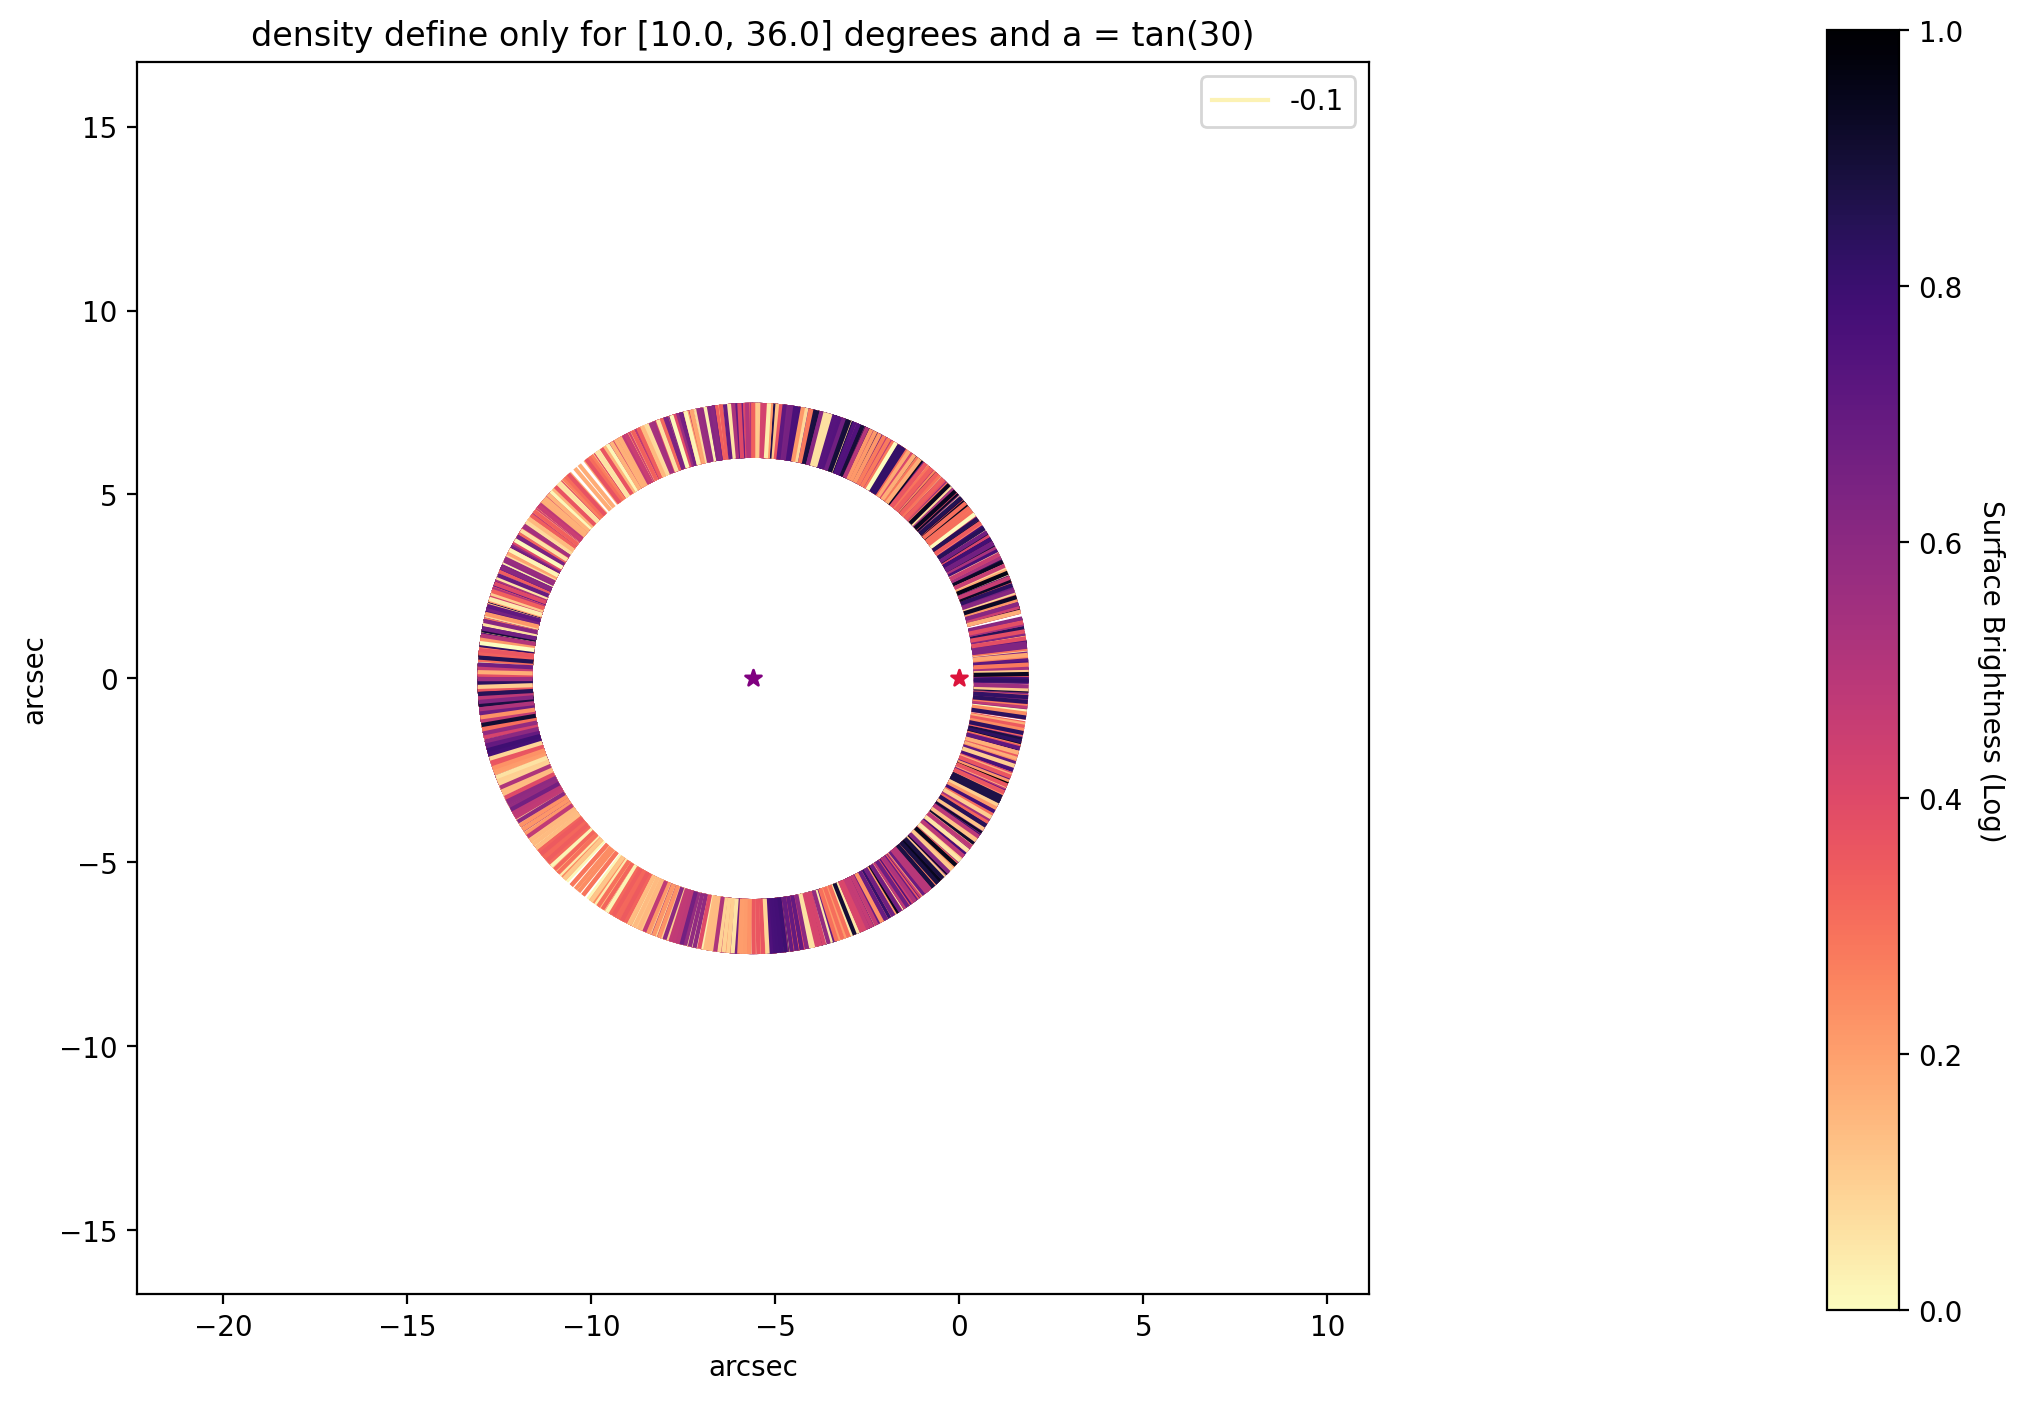

In [12]:
deltass_z0 = np.linspace(10, 36, 100)
alpha_deg_z0 = 30
zly = z0ly[0]
new_xs_z0, new_ys_z0, new_xs_h_z0, new_ys_h_z0, surface_z0, r_le_z0, act_z0 = several_deltas(deltass_z0, alpha_deg_z0, zly, Deltat_y)
plot_deltas(new_xs_z0, new_ys_z0, new_xs_h_z0, new_ys_h_z0, surface_z0, deltass_z0, alpha_deg_z0, r_le_z0, act_z0, [zly/pctoly])

In [17]:
deltass = np.array([np.linspace(0, 360, 100), np.linspace(10, 36, 100), np.linspace(40, 78, 100), np.linspace(234, 330, 5000)])
deltass.shape

<ipython-input-17-72a15a36bd38>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  deltass = np.array([np.linspace(0, 360, 100), np.linspace(10, 36, 100), np.linspace(40, 78, 100), np.linspace(234, 330, 5000)])


(4,)

In [18]:
deltass[0].shape

(100,)

In [19]:
np.linspace(0, 360, 100).shape

(100,)

<ipython-input-4-93c2c970093f>:17: RuntimeWarning: divide by zero encountered in true_divide
  y_inv = ( (2 * ct * x) - ((x ** 2 - (ct)**2 ) * np.tan(np.deg2rad(delta_deg)) )) / (np.tan(np.deg2rad(delta_deg)))
<ipython-input-4-93c2c970093f>:20: RuntimeWarning: invalid value encountered in sqrt
  x_inter_inv = np.sqrt(r_le2 - y_inv**2) - a * ct
<ipython-input-4-93c2c970093f>:21: RuntimeWarning: invalid value encountered in sqrt
  x_inter_inv_n = -1*np.sqrt(r_le2 - y_inv**2) - a * ct


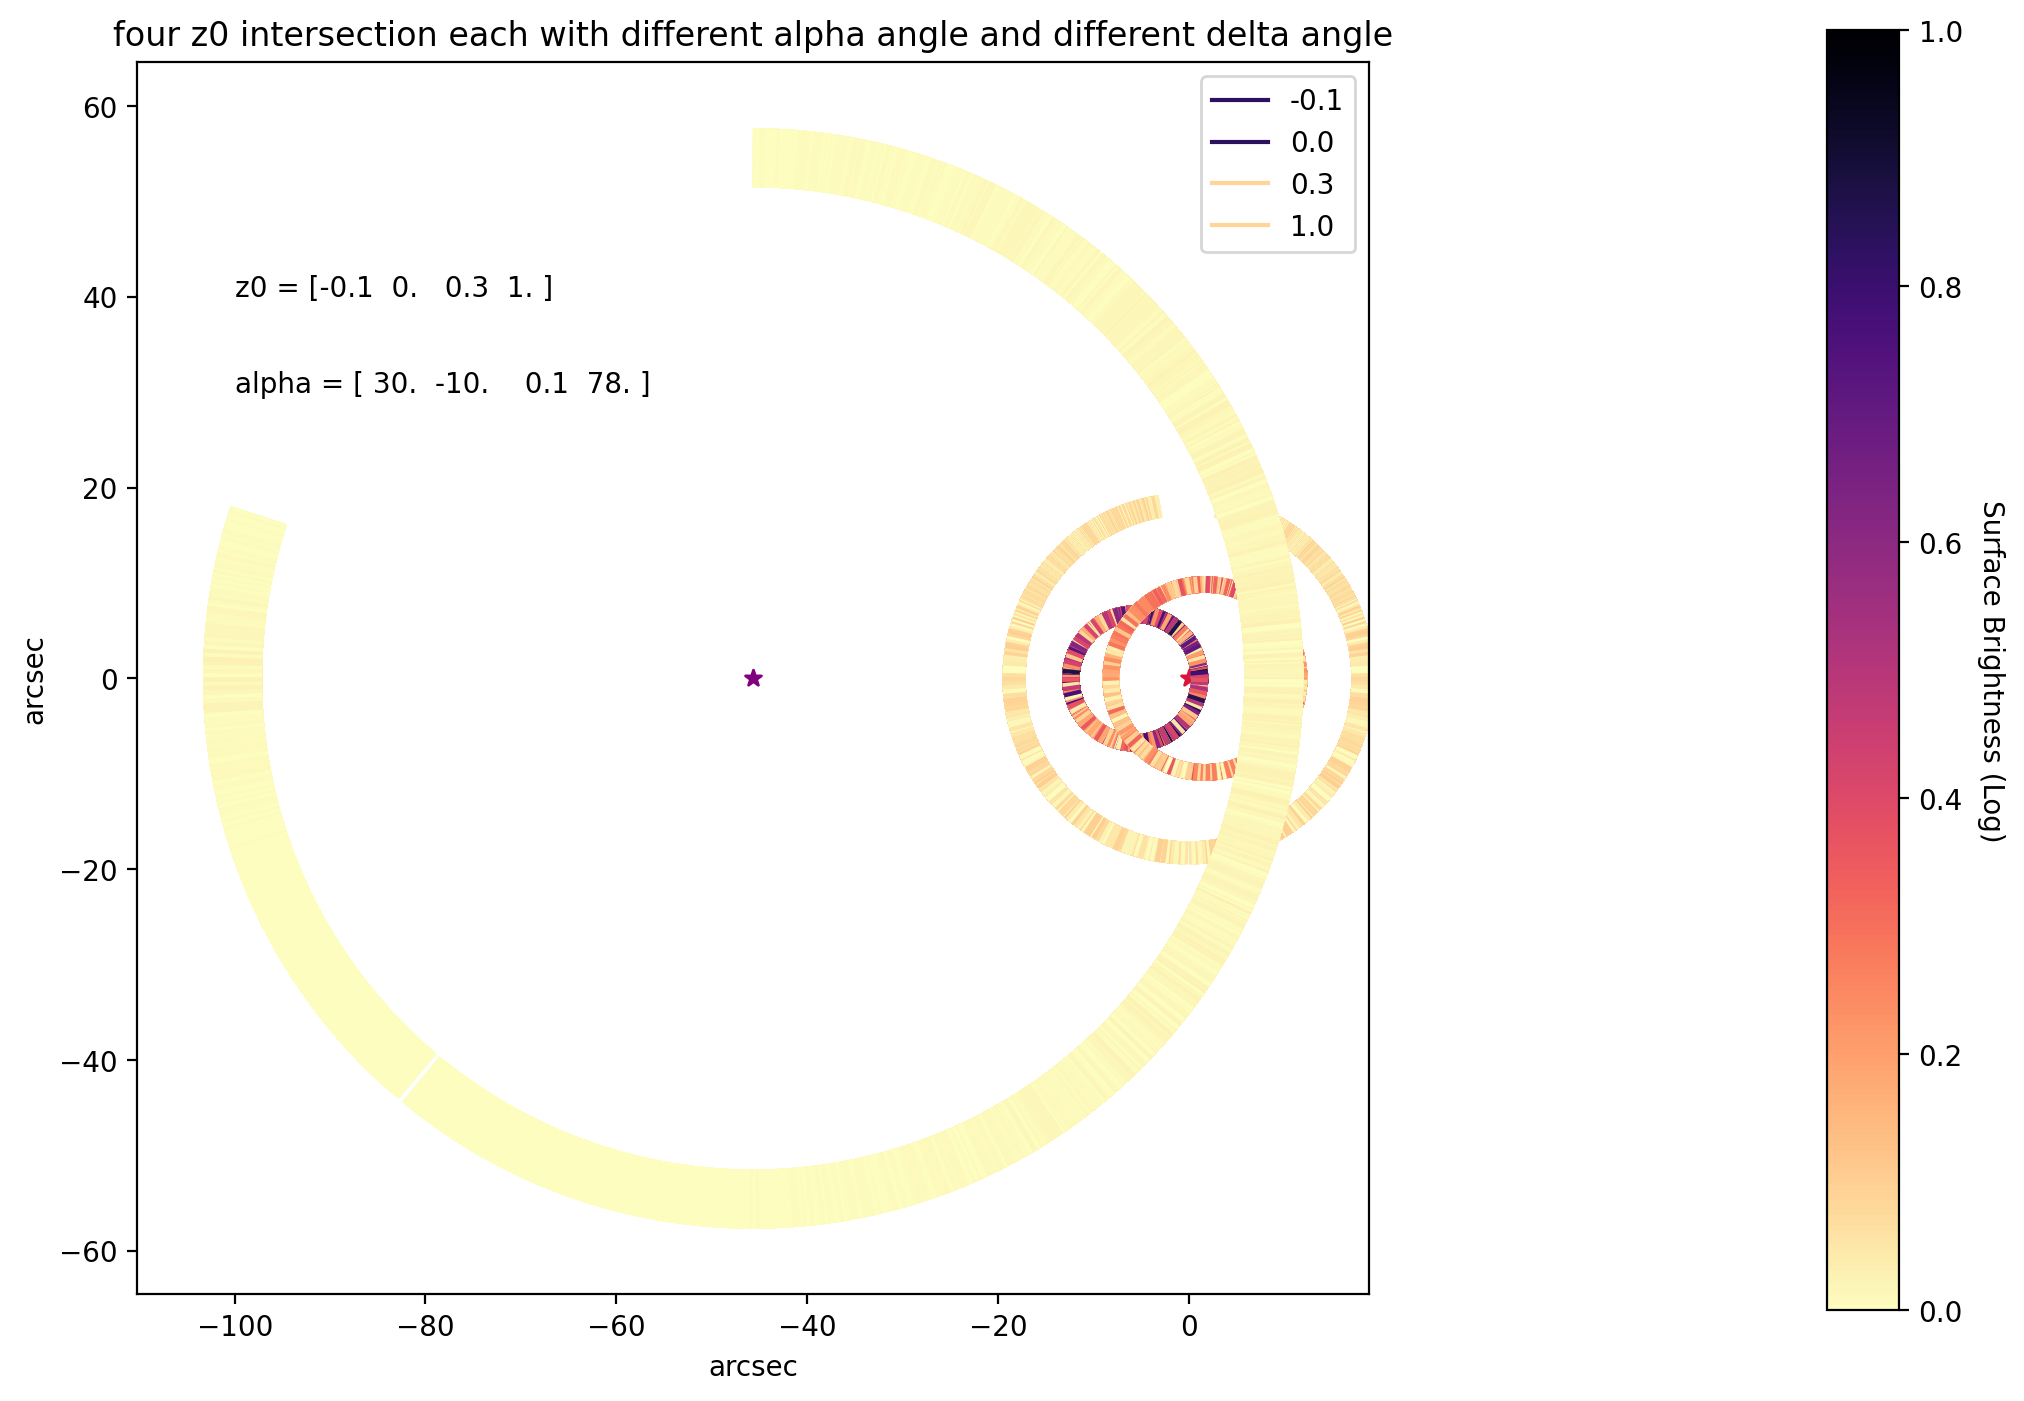

In [21]:
deltass = np.array([np.linspace(0, 360, 200), np.linspace(10, 36, 200), np.linspace(40, 78, 200), np.linspace(234, 330, 200)]).reshape(4, 200)
alpha_deg = np.array([30, -10, 0.1, 78])
# zly = z0ly[0]
new_xs_list = []
new_ys_list = []

new_xs_h_list = []
new_ys_h_list = []

surface_list = []

for zz in range(len(z0ly)):
  new_xs, new_ys, new_xs_h, new_ys_h, surface, r_le, act = several_deltas(deltass[zz], alpha_deg[zz], z0ly[zz], Deltat_y)
  new_xs_list.append(new_xs)
  new_ys_list.append(new_ys)
  new_xs_h_list.append(new_xs_h)
  new_ys_h_list.append(new_ys_h)
  surface_list.append(surface)

new_xs = np.concatenate(new_xs_list, axis = 2)
new_ys = np.concatenate(new_ys_list, axis = 2)

new_xs_h = np.concatenate(new_xs_h_list, axis = 2)
new_ys_h = np.concatenate(new_ys_h_list, axis = 2)

surface = np.concatenate(surface_list)
fig, ax = plot_deltas(new_xs, new_ys, new_xs_h, new_ys_h, surface, deltass[0], alpha_deg[0], r_le, act, z0ly/pctoly)

ax.set_title("four z0 intersection each with different alpha angle and different delta angle")
ax.text(-100, 40, "z0 = %s"%(z0ly / pctoly))
ax.text(-100, 30, "alpha = %s"%(alpha_deg))

plt.show()

<ipython-input-4-93c2c970093f>:17: RuntimeWarning: divide by zero encountered in true_divide
  y_inv = ( (2 * ct * x) - ((x ** 2 - (ct)**2 ) * np.tan(np.deg2rad(delta_deg)) )) / (np.tan(np.deg2rad(delta_deg)))
<ipython-input-4-93c2c970093f>:20: RuntimeWarning: invalid value encountered in sqrt
  x_inter_inv = np.sqrt(r_le2 - y_inv**2) - a * ct
<ipython-input-4-93c2c970093f>:21: RuntimeWarning: invalid value encountered in sqrt
  x_inter_inv_n = -1*np.sqrt(r_le2 - y_inv**2) - a * ct


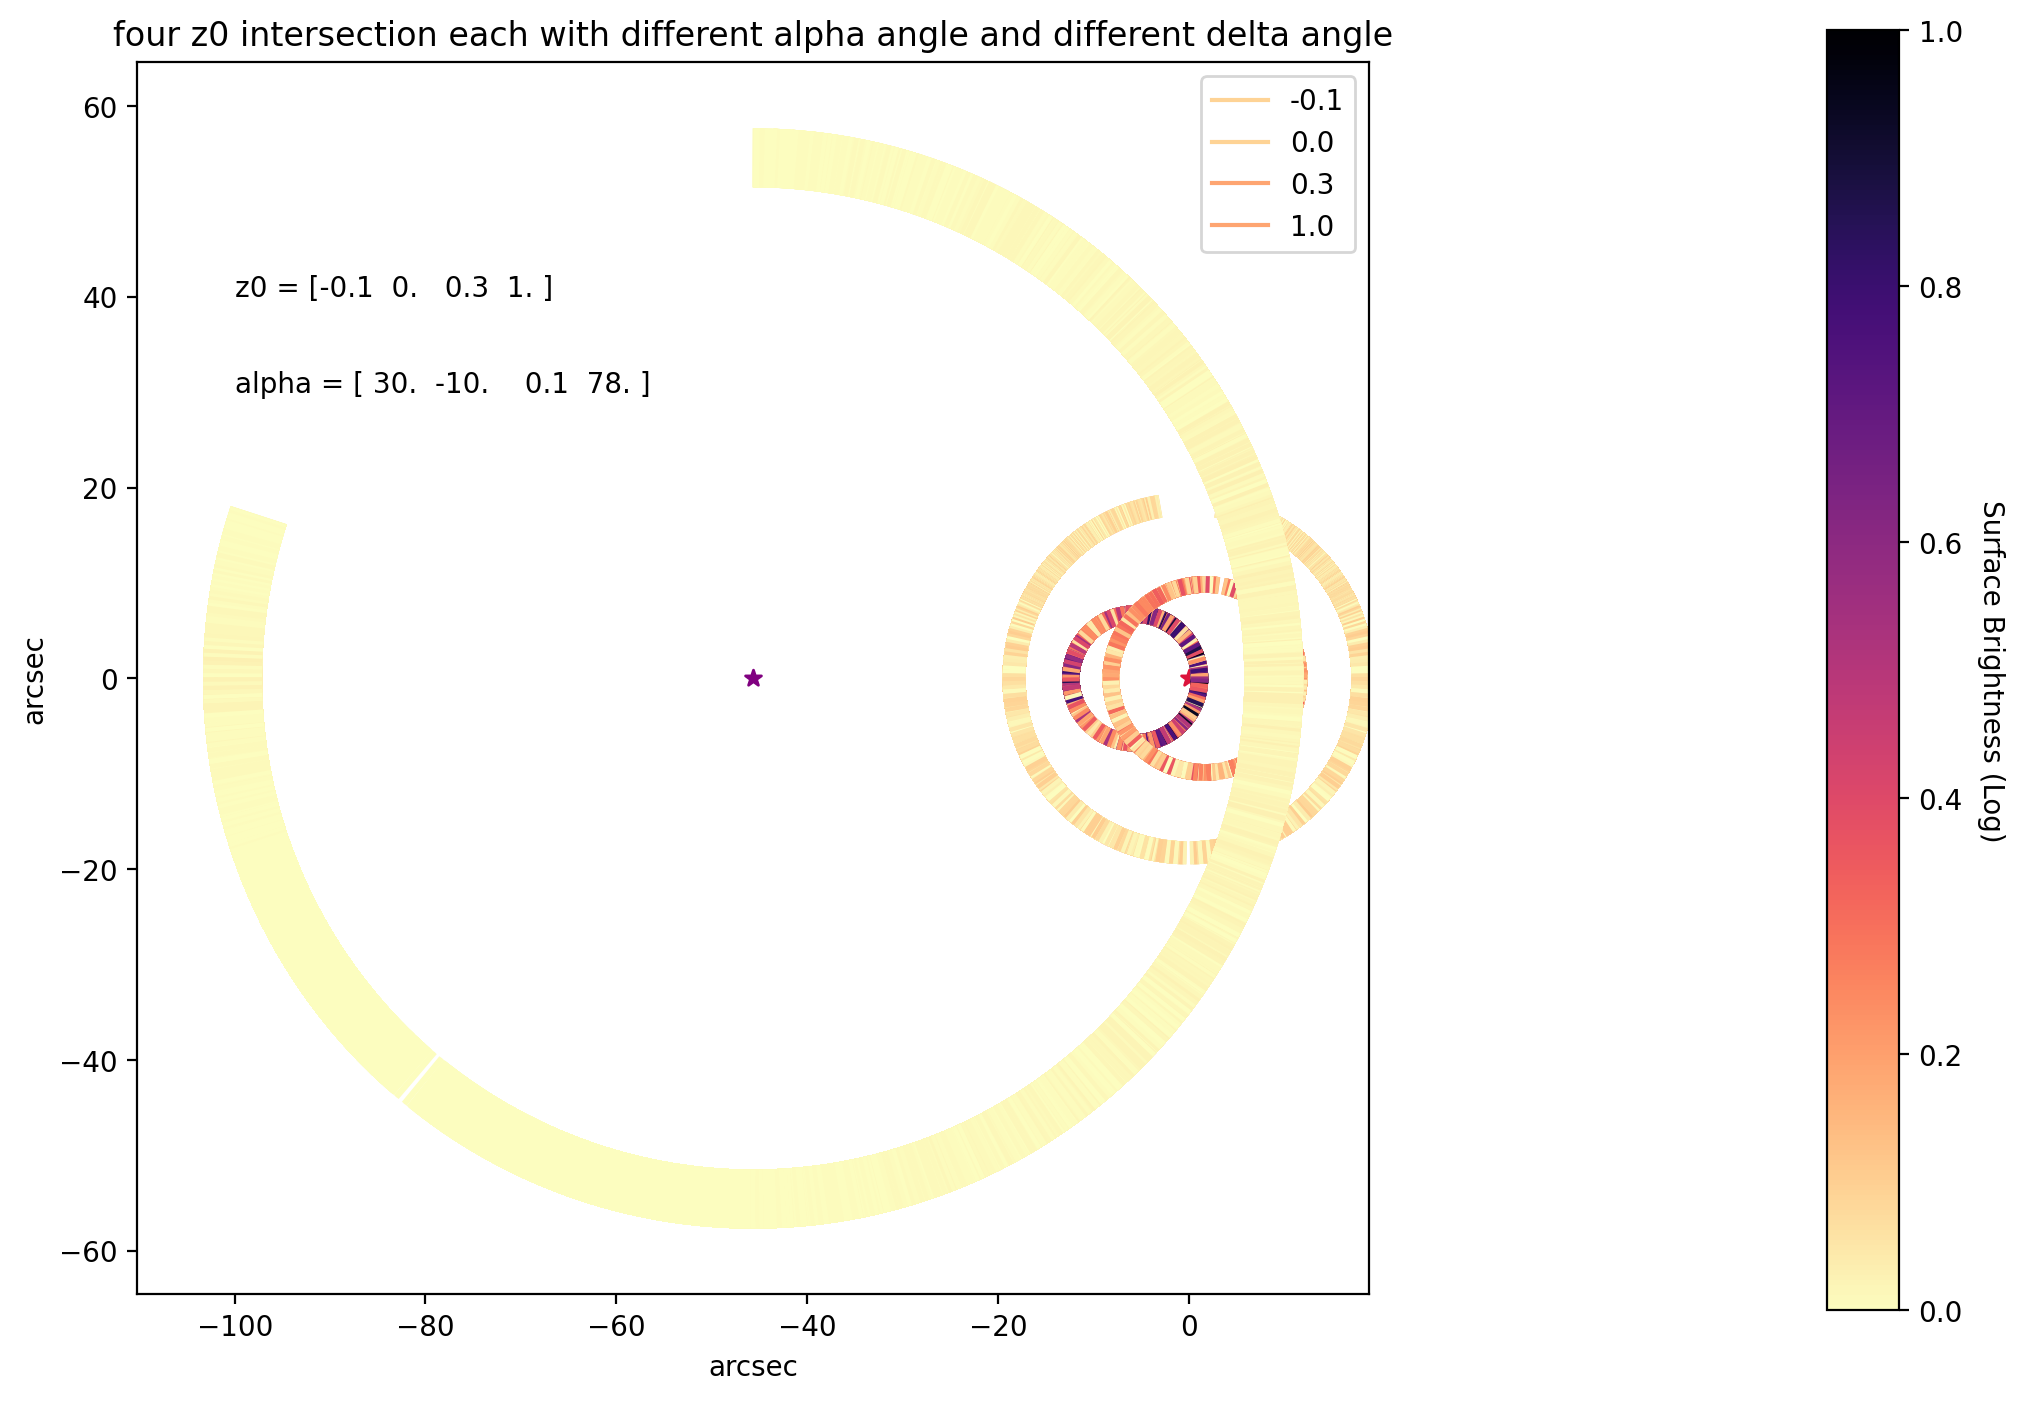

In [22]:
deltass = np.array([np.linspace(0, 360, 100), np.linspace(10, 36, 100), np.linspace(40, 78, 100), np.linspace(234, 330, 100)]).reshape(4, 100)
alpha_deg = np.array([30, -10, 0.1, 78])
# zly = z0ly[0]
new_xs_list = []
new_ys_list = []

new_xs_h_list = []
new_ys_h_list = []

surface_list = []

for zz in range(len(z0ly)):
  new_xs, new_ys, new_xs_h, new_ys_h, surface, r_le, act = several_deltas(deltass[zz], alpha_deg[zz], z0ly[zz], Deltat_y)
  new_xs_list.append(new_xs)
  new_ys_list.append(new_ys)
  new_xs_h_list.append(new_xs_h)
  new_ys_h_list.append(new_ys_h)
  surface_list.append(surface)

new_xs = np.concatenate(new_xs_list, axis = 2)
new_ys = np.concatenate(new_ys_list, axis = 2)

new_xs_h = np.concatenate(new_xs_h_list, axis = 2)
new_ys_h = np.concatenate(new_ys_h_list, axis = 2)

surface = np.concatenate(surface_list)
fig, ax = plot_deltas(new_xs, new_ys, new_xs_h, new_ys_h, surface, deltass[0], alpha_deg[0], r_le, act, z0ly/pctoly)

ax.set_title("four z0 intersection each with different alpha angle and different delta angle")
ax.text(-100, 40, "z0 = %s"%(z0ly / pctoly))
ax.text(-100, 30, "alpha = %s"%(alpha_deg))

plt.show()